<a href="https://colab.research.google.com/github/mvadrev/Emulation/blob/main/Mukund_updated_ukf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import numpy as np
from numpy.linalg import norm
from math import sqrt
from scipy.linalg import cholesky
from scipy import linalg
from math import atan2

def f_radar(x, dt):
    """ state transition function for a constant velocity
    aircraft with the state vector [distance, velocity, altitude]"""
    return (np.array([[1, dt, 0],
                  [0,  1, 0],
                  [0,  0, 1]], dtype=float)) @ x

def h_radar(x, radar_pos):
  """Measurement function, return a list [slant_range, elevation_angle]"""
  dim_x = x[0] - radar_pos[0]
  dim_y = x[2] - radar_pos[1]

  slant_range = sqrt(dim_x**2 + dim_y**2)
  elevation_angle = np.arctan2(dim_y, dim_x)
  return slant_range, elevation_angle

In [45]:
class RadarStation:

    def __init__(self, pos, range_std, elev_angle_std):
        self.pos = np.asarray(pos)       
        self.range_std = range_std
        self.elev_angle_std = elev_angle_std


    def reading_of(self, ac_pos):
        """ Returns (range, elevation angle) to aircraft.
        Elevation angle is in radians.
        """
        return norm(np.subtract(ac_pos, self.pos)), atan2(np.subtract(ac_pos, self.pos)[1], np.subtract(ac_pos, self.pos)[0])
        


    def noisy_reading(self, ac_pos):
        """ Compute range and elevation angle to aircraft with
        simulated noise"""
        range, elevation = self.reading_of(ac_pos)      
        range += np.random.randn() * self.range_std
        elevation += np.random.randn() * self.elev_angle_std 
        return range , elevation       



class ACSim:   
    def __init__(self, pos, vel, vel_std):
        self.position = np.asarray(pos, dtype=np.float64)
        self.velocity = np.asarray(vel, dtype=np.float64)
        self.velocity_std = vel_std       

        
    def update(self, dt):
        """ Compute and returns next position. Incorporates 
        random variation in velocity. """
        
        dx = self.velocity*dt + (np.random.randn() * self.velocity_std) * dt      
        self.position += dx     
        return self.position

In [46]:
from numpy.linalg import norm
from math import sqrt
from scipy.linalg import cholesky
from scipy import linalg



class UKF:
  def __init__(self, dim_x, dim_z, fx, hx, radar_pos, dt):
    self.radar_pos = radar_pos
    self.dt = dt
    self.fx = fx
    self.hx = hx

    self.mu = np.zeros(dim_x)
    self.Sigma = np.eye(dim_x)
    self.mup = np.zeros(dim_x)
    self.Sigmap = np.zeros(dim_x)
    self.z = np.zeros(dim_z)
    self.Q = np.eye(dim_z)
    self.R = np.eye(dim_x)
    self.K = np.zeros((dim_x, dim_z))
    self.y = np.zeros(dim_z)
  
  def SigmaPoints(self):
    lambda_, _, _ = self.MerweWeightSigmaPoints()
    n = len(self.mu)
    sigmas = np.zeros((2*n+1, n))
    U = linalg.cholesky((n+lambda_) * self.Sigma) # sqrt

    sigmas[0] = self.mu
    for k in range (n):
        sigmas[k+1]   = self.mu + U[k]
        sigmas[n+k+1] = self.mu - U[k]
    return sigmas

  def MerweWeightSigmaPoints(self, alpha=.1, beta=2., kappa=0.):
    n = len(self.mu)
    lambda_ = alpha**2 * (n + kappa) - n
    wc = np.full(2*n + 1,  1. / (2*(n + lambda_)))
    wm = np.full(2*n + 1,  1. / (2*(n + lambda_)))
    wc[0] = lambda_ / (n + lambda_) + (1. - alpha**2 + beta)
    wm[0] = lambda_ / (n + lambda_)
    return lambda_, wc, wm

  def unscented_transform(self, sigmas, R):

      _, wc, wm = self.MerweWeightSigmaPoints()
      mu = np.dot(wm, sigmas)
      kmax, n = sigmas.shape
      P = np.zeros((n, n))
      for k in range(kmax):
          y = sigmas[k] - mu
          P += wc[k] * np.outer(y, y)
      P += R
      return mu, P

  def predict(self):
      # calculate sigma points for given mean and covariance
      y = self.SigmaPoints()
      sigmas_f = np.zeros(y.shape)

      for i in range(len(sigmas_f)):
        sigmas_f[i] = self.fx(y[i], dt)

      self.muP, self.SigmaP = self.unscented_transform(sigmas_f, self.R)

      return self.muP, self.SigmaP, sigmas_f 

  def update(self, z):
    self.mup, self.Sigmap, sigmas_f = self.predict()
    _, wc, wm = self.MerweWeightSigmaPoints()
    sigmas_h = np.zeros(shape=(len(sigmas_f), len(z)))

    # transform sigma points into measurement space

    for i in range(len(sigmas_f)):
        sigmas_h[i] = self.hx(sigmas_f[i], radar_pos)

    # mean and covariance of prediction passed through UT
    zp, Pz = self.unscented_transform(sigmas_h, self.Q)

    # compute cross variance of the state and the measurements
    Pxz = np.zeros((len(self.mup), len(zp)))
    for i in range(len(sigmas_f)):
        Pxz += wc[i] * np.outer(sigmas_f[i] - self.mup, sigmas_h[i] - zp)

    K = np.dot(Pxz, np.linalg.inv(Pz)) # Kalman gain

    self.mu = self.mup + np.dot(K, z - zp)
    self.Sigma = self.Sigmap - np.dot(K, Pz).dot(K.T)
    return self.mu, self.Sigma




In [47]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_radar(xs, t, plot_x=True, plot_vel=True, plot_alt=True):
    xs = np.asarray(xs)
    if plot_x:
        plt.figure()
        plt.plot(t, xs[:, 0]/1000.)
        plt.xlabel('time(sec)')
        plt.ylabel('position(km)')
        plt.tight_layout()
    if plot_vel:
        plt.figure()
        plt.plot(t, xs[:, 1])
        plt.xlabel('time(sec)')
        plt.ylabel('velocity')
        plt.tight_layout()
    if plot_alt:
        plt.figure()
        plt.plot(t, xs[:,2])
        plt.xlabel('time(sec)')
        plt.ylabel('altitude')
        plt.tight_layout()
    plt.show()

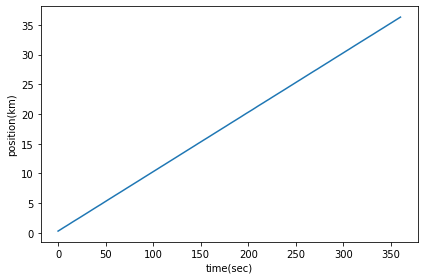

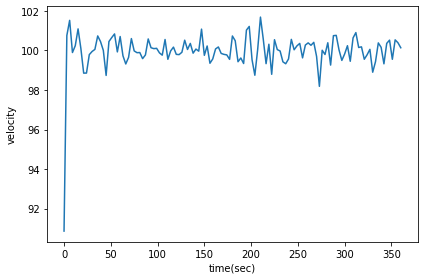

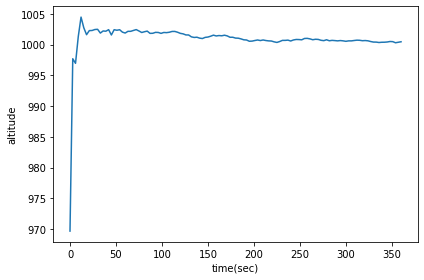

In [48]:
import math
import random

dt = 3. # 12 seconds between readings
range_std = 5 # meters
elevation_angle_std = math.radians(0.5)
ac_pos = (0., 1000.)
ac_vel = (100., 0.)
radar_pos = (0., 0.)

# state of the aircraft
x=np.array([10, 20, 30])

kf = UKF(3, 2, fx=f_radar, hx=h_radar, radar_pos = (0,0), dt = dt)

kf.R[0:2, 0:2] = np.array([[2.025, 1.35 ], [1.35 , 0.9  ]])
kf.R[2,2] = 0.1

kf.Q = np.diag([range_std**2, elevation_angle_std**2])
kf.mu = np.array([0., 90., 1000.])
kf.Sigma = np.diag([300**2, 30**2, 150**2])

np.random.seed(200)
pos = (0, 0)
radar = RadarStation(pos, range_std, elevation_angle_std)
ac = ACSim(ac_pos, (100, 0), 0.02)

time = np.arange(0, 360 + dt, dt)
xs = []
for _ in time:
    ac.update(dt)
    r = radar.noisy_reading(ac.position)
    kf.predict()
    kf.update([r[0], r[1]])
    xs.append(kf.mu)
plot_radar(xs, time)


In [49]:
# Student name: Srinivas Mukund Vadrev
# Student number: x2020fvn, 202005966
# Assignment 1 - Mobile Robotics - 3/13/2022
import numpy as np
from numpy.linalg import norm
from math import sqrt
from scipy.linalg import cholesky
from scipy import linalg
from math import atan2

def f_radar(x, dt):
    """ state transition function for a constant velocity
    aircraft with the state vector [distance, velocity, altitude]"""
    return (np.array([[1, dt, 0, 0],
                  [0,  1, 0, 0],
                  [0,  0, 1, dt],
                  [0,  0, 0, 1]], dtype=float) @ x)

def h_radar(x, radar_pos):
  """Measurement function, return a list [slant_range, elevation_angle]"""
  dim_x = x[0] - radar_pos[0]
  dim_y = x[2] - radar_pos[1]

  slant_range = sqrt(dim_x**2 + dim_y**2)
  elevation_angle = np.arctan2(dim_y, dim_x)
  return slant_range, elevation_angle

In [50]:
def plot_altitude(xs, t, track):
    xs = np.asarray(xs)

    plt.plot(t, xs[:,2], label='filter', )
    plt.plot(t, track, label='Aircraft', lw=2, ls='--', c='k')
    plt.xlabel('time(sec)')
    plt.ylabel('altitude')
    plt.legend(loc=4)

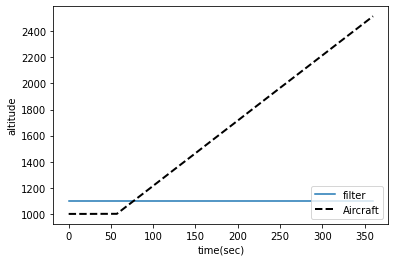

In [51]:
kf.x = np.array([0., 90., 1100.])
kf.P = np.diag([300**2, 30**2, 150**2])
ac = ACSim(ac_pos, (100, 0), 0.02)

np.random.seed(200)
time = np.arange(0, 360 + dt, dt)
xs, ys = [], []
for t in time:
    if t >= 60:
        ac.velocity[1] = 300/60 # 300 meters/minute climb
    ac.update(dt)
    r = radar.noisy_reading(ac.position)
    ys.append(ac.position[1])
    kf.predict()
    kf.update([r[0], r[1]])
    xs.append(kf.x)

plot_altitude(xs, time, ys)